In [52]:
import pandas as pd

test_results = pd.read_csv("test_results.txt")
test_results.drop(test_results.columns[0], axis=1, inplace=True)
user_table = pd.read_csv("user_table.txt")


df = test_results.merge(user_table, on ='user_id')





In [53]:
df.drop(columns = ['lat', 'long', 'user_id', 'country'], inplace=True)
df['operative_system']=df.groupby('device').operative_system.transform(lambda x: x.fillna(x.mode()[0]))
df = df.fillna(df.mode().iloc[0])
print(df['timestamp'][0])

df['timestamp'] =df['timestamp'].str.replace('60', '00')
df['timestamp'] =pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S', errors = 'coerce')
print(df['timestamp'][0].hour)
print(type(df['timestamp'][0]))


df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month
df['weekday'] = df['timestamp'].dt.weekday
df['year'] = df['timestamp'].dt.year


2015-05-08 03:38:34
3
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [54]:
#check for seasonality
print(df['month'].value_counts())
#check how historical the data is
print(df['year'].value_counts())
print('hour value counts',df['hour'].value_counts())
print('weekday value counts',df['weekday'].value_counts())

df.drop(columns = ['month', 'year', 'timestamp'], inplace=True)

#check trial users were actually displayed 59

print(len(df[df['test']==1]))
print(len(df[df['price']==59.0]))

#remove inconsistent rows
df = df[(df['test']==1) & (df['price']==59.0) | (df['test']==0) & (df['price']==39.0)]

print(len(df))
df.drop(columns = ['price'], inplace=True)
#remove hours and weekdays that don't make sense
df = df.dropna()

5.0    99072
4.0    88840
3.0    87440
Name: month, dtype: int64
2015.0    275352
Name: year, dtype: int64
hour value counts 12.0    33364
11.0    29060
10.0    24336
9.0     19270
13.0    14882
16.0    14594
8.0     14415
14.0    14345
18.0    14308
17.0    14206
15.0    14168
7.0      9584
2.0      5069
5.0      5014
22.0     4979
3.0      4979
1.0      4969
0.0      4950
21.0     4890
19.0     4844
20.0     4843
6.0      4814
23.0     4782
4.0      4687
Name: hour, dtype: int64
weekday value counts 4.0    79888
5.0    64514
6.0    48706
3.0    32119
1.0    17066
0.0    16684
2.0    16375
Name: weekday, dtype: int64
99188
98244
272621


In [ ]:
#Fisher's exact test'








In [55]:
from sklearn import preprocessing
df_enc = df.drop(columns=['test'])
to_encode = ['source', 'device', 'operative_system', 'city']
le = preprocessing.LabelEncoder()


df_enc[to_encode].apply(le.fit_transform)

#for i in to_encode:
#    df_enc[i] = le.fit_transform(df_enc[i])

,source,device,operative_system,city
0,3,0,4,109
1,8,0,0,433
2,0,0,0,612
3,5,0,4,278
4,3,1,5,281
...,...,...,...,...
275611,8,1,6,398
275612,5,1,6,56
275613,1,1,5,893
275614,6,0,0,865


In [ ]:
from kmodes.kmodes import KModes

cost=[]
for k in list(range(2,11)):
        print('Iteration number:', k)
        km = KModes(n_clusters=k, n_init = 1, verbose=1)
        km.fit(df_enc)
        cost.append(km.cost_)

import numpy as np
y = np.array([i for i in range(2,11,1)])
import matplotlib.pyplot as plt

plt.plot(y,cost)
plt.show()

In [24]:
#choose k=3
km = KModes(n_clusters=3, n_init = 1, verbose=1)
clusters = km.fit_predict(df_enc)

print('done with kmodes')





Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4155, cost: 929700.0
done with kmodes


In [56]:
df_renc = df_enc.copy()


df_renc[to_encode].apply(le.fit_transform)

source
direct_traffic     52200
ads-google         50942
ads_facebook       45772
ads_other          25748
seo-google         19905
ads-bing           19607
seo_facebook       18229
friend_referral    17785
seo-other           7939
ads-yahoo           6499
seo-yahoo           5890
seo-bing            1843
Name: source, dtype: int64
device
mobile    160397
web       111962
Name: device, dtype: int64
operative_system
iOS        95739
windows    90303
android    64492
mac        21553
i0S           97
wnddows       83
anroid        69
apple         23
Name: operative_system, dtype: int64
city
New York       25438
Chicago         7077
Houston         6626
San Antonio     4574
Los Angeles     4091
               ...  
East Lake          1
Ocala              1
New Milford        1
Cerritos           1
Costa Mesa         1
Name: city, Length: 923, dtype: int64


In [57]:
df_ind_res = df_renc.reset_index()

clustersDf = pd.DataFrame(clusters)
clustersDf.columns = ['cluster_predicted']
df_clusters = pd.concat([clustersDf, df_ind_res], axis = 1).reset_index()
df_clusters = df_clusters.drop(['index', 'level_0'], axis = 1)



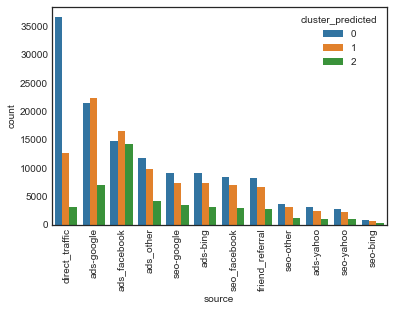

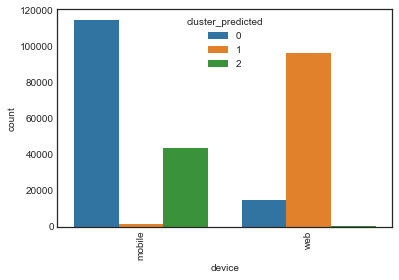

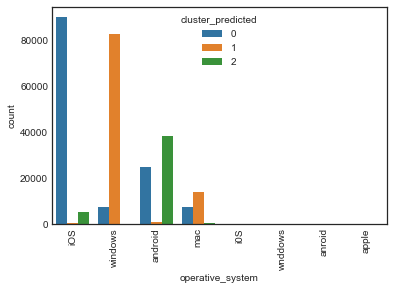

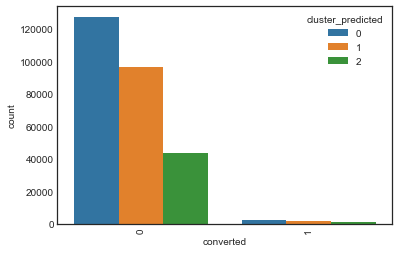

In [ ]:
from matplotlib import style
style.use('seaborn-white')
import matplotlib.pyplot as plt
import seaborn as sns
cols_clusters = ['source','device', 'operative_system','converted','city','hour','weekday']


for col in df_enc.columns:
    #plt.subplots(figsize = (15,5))
    sns.countplot(x=df_clusters[col],order=df_clusters[col].value_counts().index,hue=df_clusters['cluster_predicted'])
    degrees = 90
    plt.xticks(rotation=degrees)
    plt.show()